<a href="https://colab.research.google.com/github/Mahrukhw/south-africa-chapter-mapping-urban-v/blob/main/Model_Training_(k_means).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Using K-means Clustering
Image Segmentation using k-means clustering

In [1]:
!pip3 install opencv-python numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#importing the libraries
from sklearn.preprocessing import StandardScaler
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import keras
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
%matplotlib inline
#import K-Means
from sklearn.cluster import KMeans
# important metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path='/content/drive/MyDrive/CompleteData/'
!ls

print(path)
!ls

drive  sample_data
/content/drive/MyDrive/CompleteData/
drive  sample_data


In [7]:
data = []
label = []
c = 0
d = 0
IMG_SIZE = 300
for file in os.listdir(path):
    img=cv2.imread(path+file)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    #img=cv2.resize(img, IMG_SIZE)
    img=img.astype('float32')
    if file[:3]=='violent':
        if c==500: continue
        c+=1
        label.append("violent")
    else:
        if d==500: continue
        d+=1
        label.append("nonviolent")
    data.append(img)
data = np.array(data)




# Prepocessing

In [8]:
#We have stored all labels in integer format to data_label.
#Contents of data_label will be 0 and 1. 0 for the violent and 1 for the nonviolent.
data_label = []
for i in label:
    if i=="violent": data_label.append(0)
    else: data_label.append(1)
data_label = np.array(data_label)

In [9]:
#With this step we have first normalized the values then we flattened each 300*300*3 image to 307 values. 
#This step is crucial because k-means does not accept data with more than 2 dimensions.
#In reshaped_data contains 1000 images of 3072 sizes.

data = data/255.0
reshaped_data = data.reshape(len(data),-1)

In [10]:
reshaped_data.shape

(500, 270000)

# STANDARD KMEANS


In [11]:
#standard code for k-means clustering defined in sklearn.
#kmeans.cluster_centers_ contains 2 centroids with 3072 sizes.
#These centroids may or may not lie on images from the dataset.
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(2, 270000)

In [12]:
kmeans.cluster_centers_.shape

(2, 270000)

# SCATTER PLOT OF CENTROIDS

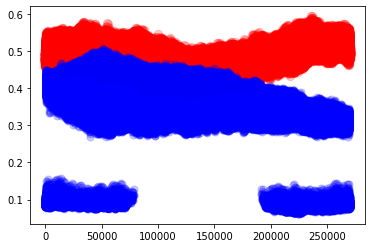

In [13]:
x_data = [i for i in range(270000)]
plt.scatter(x_data,kmeans.cluster_centers_[0], color = 'red',alpha=0.2,s=70)
plt.scatter(x_data,kmeans.cluster_centers_[1] , color = 'blue',alpha=0.2,s=50)

This shows that K-Means will be confused while classification. The best value is where they both are completely separated. We have used the x-axis of 270000 because that is the size of our image. And plotted image value in the y-axis.

# MAPPING THE LABELS

In [14]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters,data_label):
    reference_label = {}
    # For loop to run through each label of cluster label
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i,1,0)
        num = np.bincount(data_label[index==1]).argmax()
        reference_label[i] = num
    return reference_label
# Mapping predictions to original labels
def get_labels(clusters,refernce_labels):
    temp_labels = np.random.rand(len(clusters))
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
    return temp_labels

K-Means do not have any information about the labels of our actual dataset as it works by randomly picking up points and assigning clusters. So we need to map the points such that they match the real labels. get_reference_dict maps the clusters to the original data label while get_labels maps the referenced labels with the predicted values.

checking the accuracy of our model.

In [15]:
reference_labels = get_reference_dict(clusters,data_label)
predicted_labels = get_labels(clusters,reference_labels)
print(accuracy_score(predicted_labels,data_label))

1.0


# ELBOW METHOD

Accuracy for k = 2:  1.0
Accuracy for k = 16:  1.0
Accuracy for k = 64:  1.0
Accuracy for k = 100:  1.0
Accuracy for k = 256:  1.0


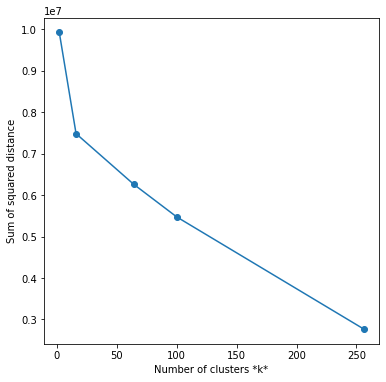

In [27]:
sse = []
list_k = [2,16,64,100,256]
for k in list_k:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters,data_label)
    predicted_labels = get_labels(clusters,reference_labels)
    print(f"Accuracy for k = {k}: ", accuracy_score(predicted_labels,data_label))
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

# Transfer Learning

In [17]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
#importing libraries
import keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image

In [19]:
#MODEL
#For Transfer Learning Model we are using ResNet50 with ‘imagenet’ weights because of its simplicity.
#You can use any model for example VGG16, VGG19, DenseNet whichever you feel like.



In [20]:
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE,3))


94765736/94765736 [==============================] - 1s 0us/step


# FEATURE EXTRACTION

In [21]:
from tensorflow.keras.preprocessing.image import img_to_array
def extract_vector(data_holder):

    resnet_feature_list = []

    for im in data_holder:
        im = image.img_to_array(im)
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())
    return np.array(resnet_feature_list)

# KMEANS MODIFIED

In [22]:
array = extract_vector(data)
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(array)

1/1 [==============================] - 0s 22ms/step


In [24]:
#kmeans.cluster_centers.shape
kmeans.cluster_centers_.shape

(2, 204800)